**Objective**: Analyzing the performance of both stocks and ETFs using historical data, with the focus on querying big data using Spark SQL to derive meaningful insights.

**Tools**: Spark, HDFS, and PySpark for distributed data processing. Pandas, Matplotlib for visualisations

**Data**: Stock Market Data for the NASDAQ https://www.kaggle.com/datasets/jacksoncrow/stock-market-dataset.

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import input_file_name, regexp_extract
from pyspark.sql.functions import year  # Import the year function
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from pyspark.sql.functions import col, lag, corr
from pyspark.sql.window import Window
import matplotlib.ticker as ticker 

In [2]:
# Initialize Spark session
spark = SparkSession.builder.appName("Stock and ETF Data").getOrCreate()

In [3]:
# Loading stock and ETF data from HDFS
stocks_df = spark.read.csv("hdfs://namenode:9000/data/stocks/*.csv", header=True, inferSchema=True)
etfs_df = spark.read.csv("hdfs://namenode:9000/data/etfs/*.csv", header=True, inferSchema=True)

In [4]:
# Add 'symbol' column after filtering, extracting it from the file names
stocks_df = stocks_df.withColumn("symbol", regexp_extract(input_file_name(), "([A-Za-z0-9]+)\.csv", 1))
etfs_df = etfs_df.withColumn("symbol", regexp_extract(input_file_name(), "([A-Za-z0-9]+)\.csv", 1))

# Reorder columns to make 'symbol' the first column
stocks_df = stocks_df.select("symbol", "Date", "Open", "High", "Low", "Close", "Adj Close", "Volume")
etfs_df = etfs_df.select("symbol", "Date", "Open", "High", "Low", "Close", "Adj Close", "Volume")

# Exploratory Data Analysis

In [5]:
stocks_df.describe()

DataFrame[summary: string, symbol: string, Date: string, Open: string, High: string, Low: string, Close: string, Adj Close: string, Volume: string]

In [6]:
etfs_df.describe()

DataFrame[summary: string, symbol: string, Date: string, Open: string, High: string, Low: string, Close: string, Adj Close: string, Volume: string]

The Date, Open, High, Low, Close, Adj Close and Volume are all strings and this will change once the data is in Spark

In [7]:
# Check for negative prices in stocks DataFrame
stocks_df.filter((stocks_df['Close'] < 0) | (stocks_df['Open'] < 0) | 
                 (stocks_df['High'] < 0) | (stocks_df['Low'] < 0)).show()

# Check for negative volumes
stocks_df.filter(stocks_df['Volume'] < 0).show()

# Repeat the process for etfs DataFrame
etfs_df.filter((etfs_df['Close'] < 0) | (etfs_df['Open'] < 0) | 
               (etfs_df['High'] < 0) | (etfs_df['Low'] < 0)).show()
etfs_df.filter(etfs_df['Volume'] < 0).show()


+------+----+----+----+---+-----+---------+------+
|symbol|Date|Open|High|Low|Close|Adj Close|Volume|
+------+----+----+----+---+-----+---------+------+
+------+----+----+----+---+-----+---------+------+

+------+----+----+----+---+-----+---------+------+
|symbol|Date|Open|High|Low|Close|Adj Close|Volume|
+------+----+----+----+---+-----+---------+------+
+------+----+----+----+---+-----+---------+------+

+------+----+----+----+---+-----+---------+------+
|symbol|Date|Open|High|Low|Close|Adj Close|Volume|
+------+----+----+----+---+-----+---------+------+
+------+----+----+----+---+-----+---------+------+

+------+----+----+----+---+-----+---------+------+
|symbol|Date|Open|High|Low|Close|Adj Close|Volume|
+------+----+----+----+---+-----+---------+------+
+------+----+----+----+---+-----+---------+------+



There are no negative values in the stock or etf data

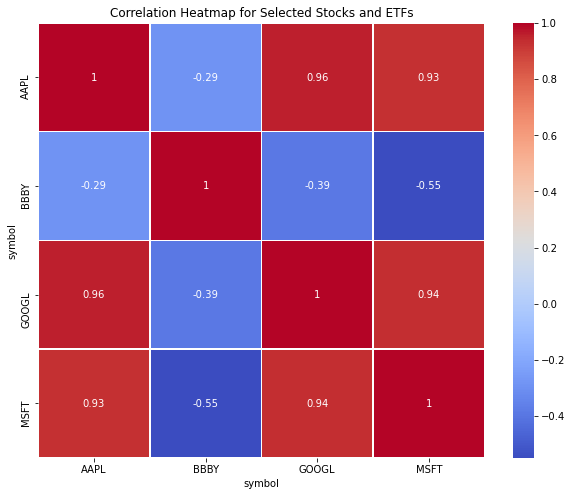

In [8]:
selected_symbols = ['AAPL', 'MSFT', 'GOOGL', 'MSFT', 'BBBY']

# Filter the dataframe for the selected symbols
filtered_df = stocks_df.filter(stocks_df['symbol'].isin(selected_symbols))

filtered_pd_df = filtered_df.toPandas()

# Pivot the dataframe to have 'Date' as index and symbols as columns, with closing prices as the values
pivot_df = filtered_pd_df.pivot(index='Date', columns='symbol', values='Close')

# Drop rows with missing values (optional, but helpful for calculating correlations)
pivot_df = pivot_df.dropna()

# Calculate the correlation matrix for the selected stocks and ETFs
correlation_matrix = pivot_df.corr()

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)

# Add title
plt.title('Correlation Heatmap for Selected Stocks and ETFs')
plt.show()

# Data Preprocessing

In [9]:
initial_stocks_count = stocks_df.count()
initial_etfs_count = etfs_df.count()
stocks_df = stocks_df.dropna()
etfs_df = etfs_df.dropna()

In [10]:
# Convert 'Date' column to date type
stocks_df = stocks_df.withColumn("Date", stocks_df["Date"].cast("date"))
etfs_df = etfs_df.withColumn("Date", etfs_df["Date"].cast("date"))

In [11]:
# Filter stocks and ETFs to only include data from 2005 onwards
stocks_df = stocks_df.filter(year(stocks_df["Date"]) >= 2005)
etfs_df = etfs_df.filter(year(etfs_df["Date"]) >= 2005)

# Count the rows after filtering
final_stocks_count = stocks_df.count()
final_etfs_count = etfs_df.count()

In [12]:
print(initial_stocks_count - final_stocks_count)
print(initial_etfs_count - final_etfs_count)

print('Final Stock Count: ' + str(final_stocks_count))
print('Final ETF Count: '+ str(final_etfs_count))

8828993
166092
Final Stock Count: 15353554
Final ETF Count: 3788224


In [13]:
# Rename "Adj Close" column to "Adj_Close"
stocks_df = stocks_df.withColumnRenamed("Adj Close", "Adj_Close")
etfs_df = etfs_df.withColumnRenamed("Adj Close", "Adj_Close")

## CRUD Operation - Update a value in the table

In [14]:
# Register DataFrames as temporary views for SQL queries
stocks_df.createOrReplaceTempView("stocks")
etfs_df.createOrReplaceTempView("etfs")

# Create the permanent tables (this time with renamed columns)
stocks_df.write.mode("overwrite").saveAsTable("stocks_table")
etfs_df.write.mode("overwrite").saveAsTable("etfs_table")

# Continue with your CRUD operation
query_update_bno_for_date = """
CREATE OR REPLACE TEMP VIEW updated_etfs AS
SELECT 
    symbol,
    Date,
    CASE 
        WHEN symbol = 'BNO' AND Date = '2018-06-15' THEN 20.45 -- Updated Close value for this specific date
        ELSE Close 
    END AS Close,
    Open,
    High,
    Low,
    Volume
FROM etfs;
"""

# Run the query to update the view
spark.sql(query_update_bno_for_date)

# Overwrite the original 'etfs_table' with the updated data
updated_etfs_df = spark.sql("SELECT * FROM updated_etfs")
updated_etfs_df.write.mode("overwrite").saveAsTable("etfs_table")

# Verify the update in the permanent 'etfs_table'
updated_bno = spark.sql("SELECT * FROM etfs_table WHERE symbol = 'BNO' AND Date = '2018-06-15'")
updated_bno.show()

+------+----------+-----+------------------+------------------+------------------+--------+
|symbol|      Date|Close|              Open|              High|               Low|  Volume|
+------+----------+-----+------------------+------------------+------------------+--------+
|   BNO|2018-06-15|20.45|20.950000762939453|20.950000762939453|20.389999389648438|303900.0|
+------+----------+-----+------------------+------------------+------------------+--------+



 # Query 1 : Moving Averages and Crossover Analysis (Golden/Death Cross)




In this section, we perform an analysis of the **50-day** and **200-day** moving averages for MSFT and AAPL and detect **Golden Cross** and **Death Cross** events. These crossover signals are often used by traders to identify potential market trends:
- **Golden Cross**: When the 50-day moving average (short-term) is **above** the 200-day moving average (long-term), it is considered a bullish signal, indicating potential price growth.
- **Death Cross**: When the 50-day moving average is **below** the 200-day moving average, it is considered a bearish signal, indicating potential price decline.

#### Spark SQL Query
We use the following Spark SQL query to compute the 50-day and 200-day moving averages for each stock. We also detect crossover events (Golden Cross or Death Cross) based on the relationship between the two moving averages.

In [15]:
# Execute the SQL query
crossover_query = """
    WITH moving_averages AS (
        SELECT 
            symbol, 
            Date, 
            Close,
            AVG(Close) OVER (PARTITION BY symbol ORDER BY Date ROWS BETWEEN 50 PRECEDING AND CURRENT ROW) AS short_term_avg,  -- 50-day moving average
            AVG(Close) OVER (PARTITION BY symbol ORDER BY Date ROWS BETWEEN 200 PRECEDING AND CURRENT ROW) AS long_term_avg   -- 200-day moving average
        FROM stocks
        WHERE symbol IN ('AAPL', 'MSFT', 'SPY')
    )
    SELECT 
        symbol,
        Date,
        Close,
        short_term_avg,
        long_term_avg,
        CASE 
            WHEN short_term_avg > long_term_avg THEN 'Golden Cross'
            WHEN short_term_avg < long_term_avg THEN 'Death Cross'
            ELSE 'No Signal'
        END AS crossover_signal
    FROM moving_averages
    ORDER BY symbol, Date
"""
crossover_df = spark.sql(crossover_query).toPandas()

# Convert the 'Date' column to datetime for proper plotting
crossover_df['Date'] = pd.to_datetime(crossover_df['Date'])

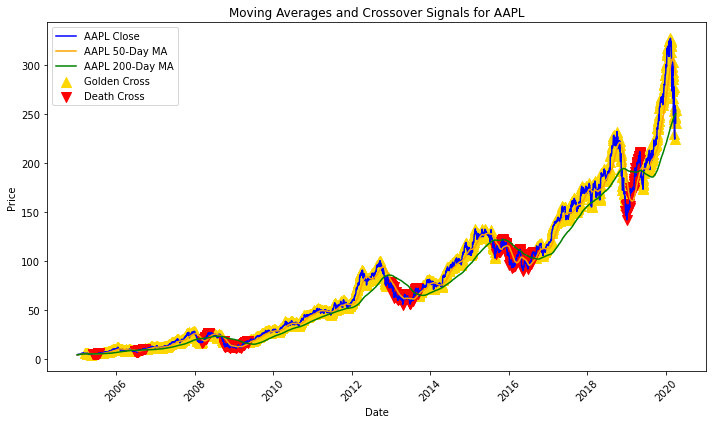

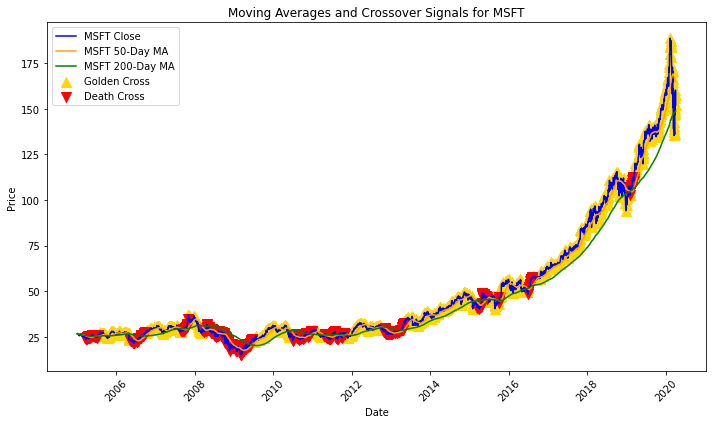

In [16]:
symbols = crossover_df['symbol'].unique()

for symbol in symbols:
    symbol_data = crossover_df[crossover_df['symbol'] == symbol]
    
    plt.figure(figsize=(10, 6))
    
    # Plot closing prices and moving averages
    plt.plot(symbol_data['Date'], symbol_data['Close'], label=f'{symbol} Close', color='blue')
    plt.plot(symbol_data['Date'], symbol_data['short_term_avg'], label=f'{symbol} 50-Day MA', color='orange')
    plt.plot(symbol_data['Date'], symbol_data['long_term_avg'], label=f'{symbol} 200-Day MA', color='green')
    
    # Highlight Golden and Death Crosses
    golden_cross = symbol_data[symbol_data['crossover_signal'] == 'Golden Cross']
    death_cross = symbol_data[symbol_data['crossover_signal'] == 'Death Cross']
    
    plt.scatter(golden_cross['Date'], golden_cross['Close'], label='Golden Cross', color='gold', marker='^', s=100)
    plt.scatter(death_cross['Date'], death_cross['Close'], label='Death Cross', color='red', marker='v', s=100)
    
    # Add labels and title
    plt.title(f'Moving Averages and Crossover Signals for {symbol}')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    
    # Rotate date labels
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

The analysis suggests that both **MSFT** and **AAPL** has been in a generally **bullish trend**, with multiple **Golden Crosses** indicating continued strength in the stock. Investors who acted on these signals might have benefited from the stock's upward movement.

Both stocks were in the **Death Cross between 2008-2010** due the 2008/9 Financial Crisis showing just how long the crisis lasted. We can observe that there was a rapid decrease in 2020 due to the COVID-19 Pandemic and yet both stocks are still in the Golden Cross 

Overall the Death Crosses occurred in shorter intervals and were often followed by temporary declines, but overall, the stock maintained its **long-term upward momentum**.

# Query 2: Volatility During 2008 Financial Crisis

### Summary of Weekly Volatility Analysis (2007-2009)

This section of the notebook calculates and compares the **weekly volatility** of selected large-cap stocks (e.g., AAPL, MSFT, AMZN) against the **SPY ETF** over the period from **2007 to 2009**. Volatility is a key measure of risk, representing the extent of price fluctuations over time. In this analysis, we focus on weekly volatility, calculated as the **standard deviation of daily returns** for each stock and the SPY ETF on a weekly basis.

#### Steps Taken:
1. **Daily Return Calculation**:
   - For each stock and the SPY ETF, the daily returns are computed as the percentage change in closing prices from one day to the next.
   - This is done for all trading days between **2007 and 2009**.

2. **Weekly Volatility Calculation**:
   - The weekly volatility is calculated as the **standard deviation** of the daily returns for each stock and the SPY ETF within each week.
   - This gives a measure of how much the stock or ETF's price fluctuates on a weekly basis, with higher standard deviation indicating greater volatility.

3. **Comparison Across Stocks and SPY ETF**:
   - The analysis compares the weekly volatility of the selected large-cap stocks (AAPL, MSFT, AMZN) with the SPY ETF, allowing for a relative comparison of their risk profiles during the financial crisis period of 2007-2009.
   - The comparison provides insights into how the volatility of individual stocks compares to that of the broader market (as represented by the SPY ETF) during this historically volatile period and whether there is an advantage in diversifying investments by investing in investing in an index fund 

#### Visualization:
- The results are plotted on a line chart that shows the **weekly volatility** for each stock and the SPY ETF over time. The x-axis represents the weeks from 2007 to 2009, and the y-axis represents the standard deviation of weekly returns.
- To improve readability, the x-axis is simplified to show fewer labels, ensuring the plot remains easy to interpret despite the large time range.

In [17]:
#crossover_df.unpersist() #free up memory
query_weekly_volatility = """
    WITH daily_returns AS (
        SELECT 
            symbol,
            year(Date) AS Year,
            WEEKOFYEAR(Date) AS Week,
            (Close - LAG(Close) OVER (PARTITION BY symbol ORDER BY Date)) / LAG(Close) OVER (PARTITION BY symbol ORDER BY Date) AS Daily_Return
        FROM stocks
        WHERE symbol IN ('AAPL', 'MSFT', 'AMZN') AND year(Date) BETWEEN 2007 AND 2009
    ),
    weekly_volatility AS (
        SELECT 
            symbol, 
            Year, 
            Week, 
            stddev(Daily_Return) AS Weekly_Volatility
        FROM daily_returns
        WHERE Daily_Return IS NOT NULL
        GROUP BY symbol, Year, Week
    ),
    spy_daily_returns AS (
        SELECT 
            'SPY' AS symbol, 
            year(Date) AS Year,
            WEEKOFYEAR(Date) AS Week,
            (Close - LAG(Close) OVER (ORDER BY Date)) / LAG(Close) OVER (ORDER BY Date) AS Daily_Return
        FROM etfs
        WHERE symbol = 'SPY' AND year(Date) BETWEEN 2007 AND 2009
    ),
    spy_weekly_volatility AS (
        SELECT 
            symbol, 
            Year, 
            Week, 
            stddev(Daily_Return) AS Weekly_Volatility
        FROM spy_daily_returns
        WHERE Daily_Return IS NOT NULL
        GROUP BY symbol, Year, Week
    )
    SELECT * FROM weekly_volatility
    UNION ALL
    SELECT * FROM spy_weekly_volatility
    ORDER BY symbol, Year, Week
"""

# Execute the SQL query and convert the result to Pandas
weekly_volatility_df = spark.sql(query_weekly_volatility).toPandas()

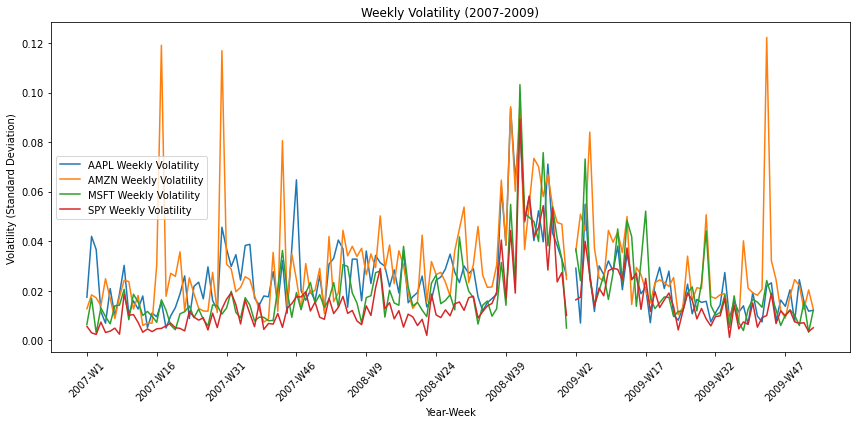

In [18]:
# Combine Year and Week into a continuous time format for easier plotting
weekly_volatility_df['Year_Week'] = weekly_volatility_df['Year'].astype(str) + '-W' + weekly_volatility_df['Week'].astype(str)

# Sort by Year and Week for correct plotting order
weekly_volatility_df = weekly_volatility_df.sort_values(by=['Year', 'Week'])

# Plot the weekly volatility comparison
plt.figure(figsize=(12, 6))
for symbol in weekly_volatility_df['symbol'].unique():
    data = weekly_volatility_df[weekly_volatility_df['symbol'] == symbol]
    plt.plot(data['Year_Week'], data['Weekly_Volatility'], label=f'{symbol} Weekly Volatility')

# Reduce the number of x-axis labels
ax = plt.gca()
ax.xaxis.set_major_locator(ticker.MaxNLocator(nbins=12))  # Limit the number of x-axis labels to 12

# Rotate x-axis labels for readability
plt.xticks(rotation=45)

plt.title('Weekly Volatility (2007-2009)')
plt.xlabel('Year-Week')
plt.ylabel('Volatility (Standard Deviation)')
plt.legend()
plt.tight_layout()
plt.show()

The analysis reveals significant spikes in volatility for AAPL, AMZN, MSFT, and SPY during the 2007-2009 financial crisis, particularly in late 2008.

AMZN exhibited the highest volatility, reflecting greater price instability compared to AAPL and MSFT.
AAPL, MSFT, and SPY followed similar volatility patterns, with **SPY having smoother fluctuations** with lower peaks.

This analysis highlights the heightened risk and uncertainty during the financial crisis and the advantage of investing in index funds where **investing in an index fund like SPY allows investors to benefit from diversification**. Rather than being exposed to the high volatility of a single stock, the index averages out the price movements of 500 companies. This reduces the impact of extreme price swings in any one stock.

# Query 3 : Sharpe Ratio

### Summary: Sharpe Ratio Analysis for Top 5 ETFs

In this analysis, I calculated and visualized the **Sharpe Ratio** for the top 5 performing ETFs based on their overall return over the available dataset.

The Sharpe Ratio is a metric in finance to measure the **risk-adjusted return** of an investment. It helps investors understand whether higher returns are being achieved due to wise investment decisions or as a result of higher risk.

#### Key Aspects:
- **Top 5 Performing ETFs**: We first identified the top 5 ETFs based on their average monthly returns across the entire dataset.
- **Sharpe Ratio Calculation**: 
  - The Sharpe Ratio was calculated for each ETF on a **weekly** basis.
  - Formula: 

    $$
    \text{Sharpe Ratio} = \frac{R_i - R_f}{\sigma_i}
    $$

    Where:
    - $R_i$ = Average weekly return of the ETF
    - $R_f$ = Risk-free rate (assumed to be 0 for simplicity in this analysis)
    - $\sigma_i$ = Standard deviation of weekly returns (as a proxy for risk)
    
    Excess Return: 
    - A positive Sharpe Ratio means that the investment is generating positive returns beyond the benchmark (zero return).

    Risk-Adjusted Performance: 
    - The returns are worth the risk. It means that the level of return is favorable when compared to the risk (volatility) of the investment.
    
- **Time Frame**: The analysis was conducted over the last month (March 2020)

#### Visualization:
- The **line plots** show the Sharpe Ratio trends over time for the top 5 performing ETFs.
- This allows us to visually compare the risk-adjusted performance of each ETF and observe how their Sharpe Ratios fluctuate over time.

By comparing the Sharpe Ratios, we can better understand which ETFs provided the best risk-adjusted returns and how their performance varied throughout the analyzed time period.



In [19]:
#del weekly_volatility_df
# Step 1: Create the filtered_daily_returns view
create_view_query = """
CREATE OR REPLACE TEMP VIEW filtered_daily_returns AS
SELECT 
    symbol, 
    Date, 
    (Close - LAG(Close) OVER (PARTITION BY symbol ORDER BY Date)) / LAG(Close) OVER (PARTITION BY symbol ORDER BY Date) AS Daily_Return
FROM etfs
WHERE symbol IS NOT NULL;
"""

# Execute the query to create the view
spark.sql(create_view_query)


# Step 2: Sharpe ratio query
query_top_5_sharpe_ratio_weekly = """
WITH etf_daily_returns AS (
    -- Calculate daily returns with year and week
    SELECT 
        symbol, 
        Date, 
        year(Date) AS Year, 
        WEEKOFYEAR(Date) AS Week, 
        Daily_Return
    FROM filtered_daily_returns
),

-- Calculate the overall Sharpe ratio for each ETF based on daily returns
etf_overall_sharpe AS (
    SELECT 
        symbol, 
        AVG(Daily_Return) AS Avg_Return, 
        STDDEV(Daily_Return) AS Volatility,
        AVG(Daily_Return) / STDDEV(Daily_Return) AS Sharpe_Ratio
    FROM etf_daily_returns
    GROUP BY symbol
),

-- Select the top 5 ETFs with the highest Sharpe ratios
top_5_etfs AS (
    SELECT symbol
    FROM etf_overall_sharpe
    ORDER BY Sharpe_Ratio DESC
    LIMIT 5
),

-- Calculate weekly returns and volatility for the top 5 ETFs
etf_weekly_returns AS (
    SELECT 
        symbol, 
        Year, 
        Week, 
        AVG(Daily_Return) AS Avg_Weekly_Return,
        STDDEV(Daily_Return) AS Weekly_Volatility
    FROM etf_daily_returns
    WHERE symbol IN (SELECT symbol FROM top_5_etfs)
    GROUP BY symbol, Year, Week
)

-- Calculate the weekly Sharpe ratio for the top 5 ETFs
SELECT 
    symbol, 
    Year, 
    Week, 
    Avg_Weekly_Return, 
    Weekly_Volatility,
    Avg_Weekly_Return / Weekly_Volatility AS Sharpe_Ratio
FROM etf_weekly_returns
ORDER BY symbol, Year, Week;
"""

# Execute the query to get the Sharpe ratio data
sharpe_ratio_trend_top_5_weekly_df = spark.sql(query_top_5_sharpe_ratio_weekly).toPandas()


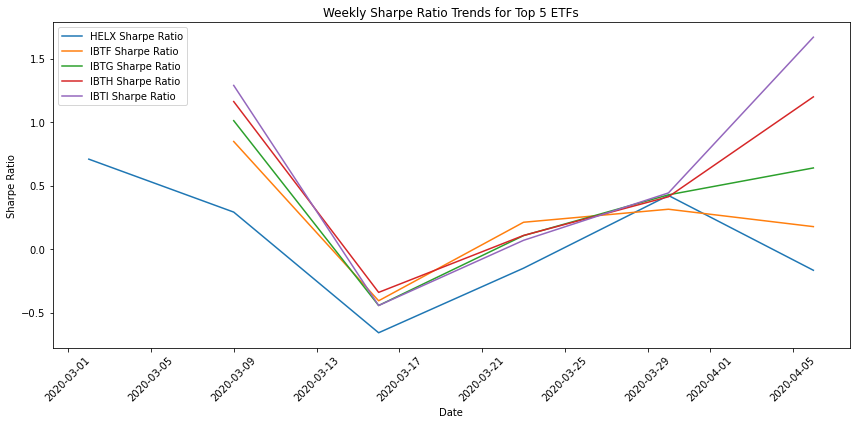

In [20]:
# Convert Year and Week to actual date (the start of each week)
sharpe_ratio_trend_top_5_weekly_df['Date'] = pd.to_datetime(sharpe_ratio_trend_top_5_weekly_df['Year'].astype(str) + sharpe_ratio_trend_top_5_weekly_df['Week'].astype(str) + '1', format='%Y%W%w')

# Plot Sharpe Ratio trends over time for the top 5 ETFs
plt.figure(figsize=(12, 6))
for symbol in sharpe_ratio_trend_top_5_weekly_df['symbol'].unique():
    data = sharpe_ratio_trend_top_5_weekly_df[sharpe_ratio_trend_top_5_weekly_df['symbol'] == symbol]
    plt.plot(data['Date'], data['Sharpe_Ratio'], label=f'{symbol} Sharpe Ratio')

# Add titles and labels
plt.title('Weekly Sharpe Ratio Trends for Top 5 ETFs')
plt.xlabel('Date')
plt.ylabel('Sharpe Ratio')
plt.legend()
plt.xticks(rotation=45)

# Show the plot
plt.tight_layout()
plt.show()


This chart shows the weekly Sharpe Ratio trends for the top 5 ETFs by sharpe ratio

- **Upward Trend**: Most ETFs (IBTF, IBTG, IBTH, IBTI) show an improvement in their Sharpe Ratios after an initial decline, suggesting better risk-adjusted performance in the latter period.
- **HELX Underperformance**: Unlike the others, HELX shows a sustained decline, indicating weaker returns relative to its risk.
- **Strong Recovery**: IBTI and IBTH exhibit strong rebounds in their Sharpe Ratios, positioning them as the top performers towards the end of the time frame.

# Query 4: High and Low Breakouts

### Summary: Normalized Stock Prices and Breakouts (Last 3 Months)

In this analysis, I focused on the performance of selected retail stocks over the **last 6 months** (from November 2019 to April 2020). The goal was to track and compare their price movements relative to each other, while also identifying key breakout points.

#### Key Aspects:
- **Normalization**: The closing prices for each stock were normalized by setting the initial price (from the start of the period) to 100. This allows for easy comparison of relative price changes, even if the stocks have different absolute price levels.
- **Breakouts**: I identified and highlighted key **breakout points**, where the stock price either exceeded the previous **12-week high** or dropped below the **12-week low**. These points help indicate moments of significant price movement.
  
#### Visualization:
- The **line plots** represent the normalized closing prices for each stock, showing how each stock's price has changed relative to its value at the start of the period.
- **Breakout points** are marked with orange dots to highlight moments where a stock either broke above or below its recent price range.

This approach offers insights into trends and volatility within the retail sector. It also highlight how the COVID-19 Pandemic caused a huge drop in stock prices in the retail sector.

In [21]:
#del sharpe_ratio_trend_top_5_weekly_df

query_52_week_breakouts = """WITH recent_data AS (
    -- Filter the data for the last 3 months leading up to April 1, 2020
    SELECT 
        symbol,
        year(Date) AS Year, 
        Close,
        Date
    FROM stocks
    WHERE symbol IN ('BBBY', 'BAX', 'BC', 'AEO')
    AND Date >= '2019-01-11'  -- Start of November 2019
    AND Date <= '2020-04-01'  -- Last available date (April 1, 2020)
),
weekly_high_low AS (
    -- Calculate the 12-week high and low for the past 3 months
    SELECT 
        symbol,
        year(Date) AS Year, 
        MAX(Close) OVER (PARTITION BY symbol ORDER BY Date ROWS BETWEEN 59 PRECEDING AND CURRENT ROW) AS high_12wk,
        MIN(Close) OVER (PARTITION BY symbol ORDER BY Date ROWS BETWEEN 59 PRECEDING AND CURRENT ROW) AS low_12wk,
        Close,
        Date
    FROM recent_data
)
SELECT 
    symbol,
    Year, 
    Date, 
    Close, 
    high_12wk, 
    low_12wk,
    CASE 
        WHEN Close >= high_12wk THEN '12-week High Breakout'
        WHEN Close <= low_12wk THEN '12-week Low Breakout'
        ELSE 'No Breakout'
    END AS breakout_status
FROM weekly_high_low
ORDER BY symbol, Year, Date
"""

# Execute the query and store the result in a DataFrame
breakout_df = spark.sql(query_52_week_breakouts).toPandas()

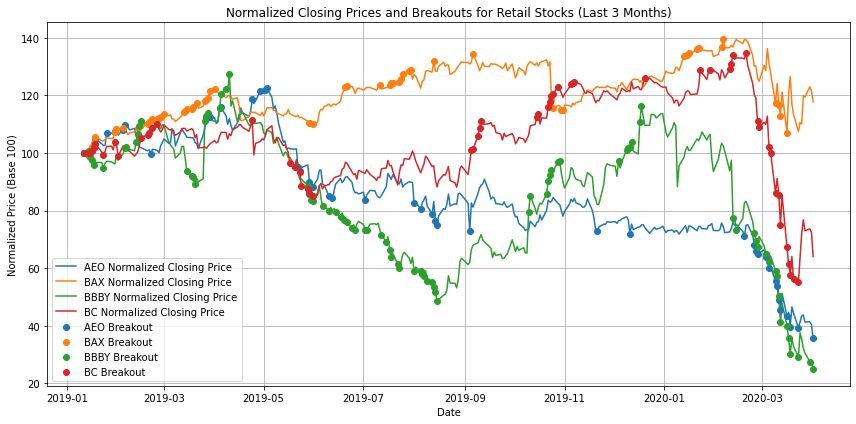

In [22]:
# Normalize the closing prices by setting the first closing price to 100 for each stock
plt.figure(figsize=(12, 6))

for symbol in breakout_df['symbol'].unique():
    data = breakout_df[breakout_df['symbol'] == symbol].copy()
    initial_price = data['Close'].iloc[0]  # Get the initial price for normalization
    data['Normalized_Close'] = (data['Close'] / initial_price) * 100  # Normalize closing price
    
    # Plot normalized closing prices
    plt.plot(data['Date'], data['Normalized_Close'], label=f'{symbol} Normalized Closing Price')
    
    # Highlight breakouts (same as before)
    breakout_data = data[data['breakout_status'] != 'No Breakout']
    plt.scatter(breakout_data['Date'], breakout_data['Normalized_Close'], label=f'{symbol} Breakout', zorder=5)

# Add titles and labels
plt.title('Normalized Closing Prices and Breakouts for Retail Stocks (Last 3 Months)')
plt.xlabel('Date')
plt.ylabel('Normalized Price (Base 100)')
plt.legend()
plt.grid(True)

# Show the plot
plt.tight_layout()
plt.show()

From the graph shown, we see that initially all the stocks were relatively consistent and in 2019 BBBY and AED experienced a consistent decline highlighted by the fact that BBBY had consistent breakouts till August 2019.

While BC and and BAX had strong growth by the end of the year. However in 2020 all stocks suffered a sharp drop in price, highlighting how the COVID-19 pandemic caused a systemic shock to the retail industry.